# Analyse statistique avancée du dataset `edu3-clinical-fr-mesh`
Ce notebook explore la qualité et la complémentarité entre les MeSH détectés par GLiNER et ceux issus de PubMed, ainsi que la couverture des codes CIM-10 associés.

In [7]:
!pip install matplotlib seaborn scikit-learn --quiet

In [8]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import chain
from sklearn.metrics import jaccard_score
import numpy as np

sns.set(style='whitegrid')

In [9]:
ds = load_dataset('clairedhx/edu3-clinical-fr-mesh', split='train')
df = pd.DataFrame(ds)

In [26]:
df['n_mesh_gliner'] = df['mesh_from_gliner'].apply(len)
df['n_mesh_pubmed'] = df['pubmed_mesh'].apply(len)
df['n_union'] = df['union_mesh'].apply(len)
df['n_inter'] = df['inter_mesh'].apply(len)
df['n_icd10'] = df['icd10_codes'].apply(len)
df['n_icd10_reduct'] = df['icd10_codes_reduct'].apply(len)
df[['n_mesh_gliner', 'n_mesh_pubmed', 'n_union', 'n_inter', 'n_icd10', 'n_icd10_reduct']].describe()

,n_mesh_gliner,n_mesh_pubmed,n_union,n_inter,n_icd10,n_icd10_reduct
count,309.000000,309.000000,309.000000,309.000000,309.000000,309.00000
mean,5.834951,6.556634,11.466019,0.925566,5.080906,3.36246
std,2.992731,3.350838,4.209950,0.888761,3.928326,2.34618
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.00000
25%,4.000000,6.000000,9.000000,0.000000,2.000000,2.00000
50%,5.000000,7.000000,11.000000,1.000000,4.000000,3.00000
75%,8.000000,9.000000,14.000000,1.000000,7.000000,5.00000
max,18.000000,14.000000,25.000000,4.000000,26.000000,13.00000


In [27]:
# Fonction Jaccard sur deux listes
def jaccard(a, b):
    a, b = set(a), set(b)
    if not a and not b:
        return np.nan
    return len(a & b) / len(a | b)

# Score global
df['jaccard_mesh'] = df.apply(lambda x: jaccard(x['mesh_from_gliner'], x['pubmed_mesh']), axis=1)
df['jaccard_mesh'].describe()

count    309.000000
mean       0.077946
std        0.077883
min        0.000000
25%        0.000000
50%        0.071429
75%        0.125000
max        0.428571
Name: jaccard_mesh, dtype: float64

In [28]:
#En ne considerant pas les lignes pourlesquelles on a aucun pubmed mesh
df_with_pubmed = df[df['n_mesh_pubmed'] > 0]
df_with_pubmed['jaccard_mesh'].describe()

count    262.000000
mean       0.091929
std        0.076601
min        0.000000
25%        0.000000
50%        0.083333
75%        0.133333
max        0.428571
Name: jaccard_mesh, dtype: float64

In [29]:
def recall_pubmed_in_gliner(pub, gl):
    if not pub:
        return np.nan
    return len(set(pub) & set(gl)) / len(set(pub))

df['recall_mesh_pubmed_in_gliner'] = df.apply(lambda x: recall_pubmed_in_gliner(x['pubmed_mesh'], x['mesh_from_gliner']), axis=1)
df['recall_mesh_pubmed_in_gliner'].describe()

count    262.000000
mean       0.143928
std        0.118849
min        0.000000
25%        0.000000
50%        0.142857
75%        0.200000
max        0.666667
Name: recall_mesh_pubmed_in_gliner, dtype: float64

Text(0.5, 0, 'Nombre de MeSH en commun')

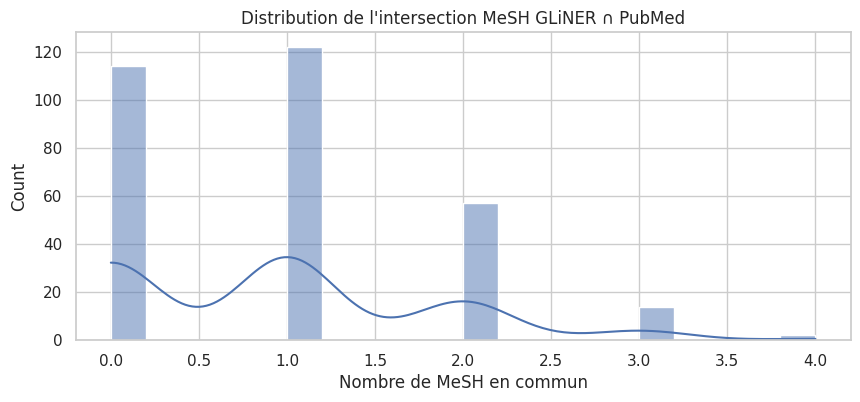

In [33]:
plt.figure(figsize=(10, 4))
sns.histplot(df['n_inter'], bins=20, kde=True)
plt.title("Distribution de l'intersection MeSH GLiNER ∩ PubMed")
plt.xlabel("Nombre de MeSH en commun")

Text(0.5, 1.0, 'Distribution des codes ICD-10 vs. ICD10_reduct')

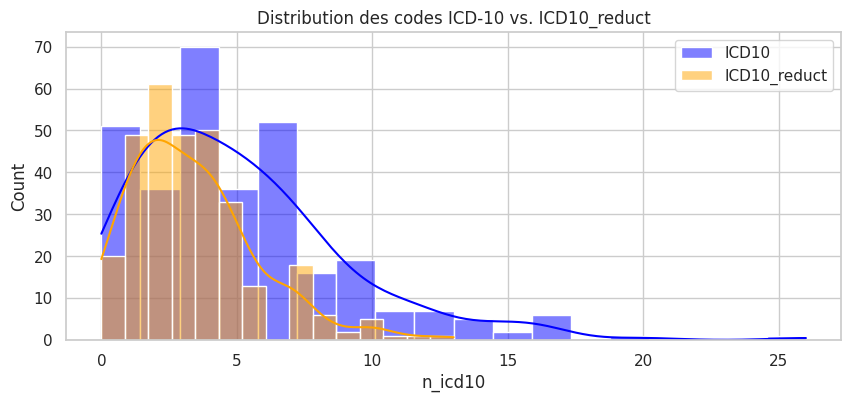

In [34]:
plt.figure(figsize=(10, 4))
sns.histplot(df['n_icd10'], color='blue', label='ICD10', kde=True)
sns.histplot(df['n_icd10_reduct'], color='orange', label='ICD10_reduct', kde=True)
plt.legend()
plt.title('Distribution des codes ICD-10 vs. ICD10_reduct')

In [35]:
icd_flat = list(chain.from_iterable(df['icd10_codes']))
pd.Series(icd_flat).value_counts().head(20)

R50.9      33
R52        28
R06.02     19
R06.0      19
R06.01     19
R06.00     19
R60.9      18
C85.9      17
Z33.1      16
D72.829    13
M54.50     11
M54.5      11
D64.9      11
R11.1      11
R11.10     11
C80.0      10
H26.9      10
D86         9
D80-D89     9
L53.9       9
Name: count, dtype: int64

In [36]:
icd_flat = list(chain.from_iterable(df['icd10_codes_reduct']))
pd.Series(icd_flat).value_counts().head(20)

R50        33
R52        28
D72        21
R06        21
R60        18
C85        17
Z33        16
M54        15
C80        14
H53        14
R11        11
D64        11
H26        10
D80-D89     9
H47         9
L53         9
R10         9
D86         9
H35         8
I10         8
Name: count, dtype: int64